#  Project — Part I: Generating a believable electricity dataset (2024)
## Name: **Uday Maduri**

Course: Python 101 – Final Project  

Goal: Generate an hourly electricity consumption dataset (kWh) for the entire year 2024 for Albstadt-Sigmaringen University. The dataset will be reproducible and explainable; it will be exported as a CSV when the notebook runs. Source: "Final project part I - Generating a believable dataset" as provided in Ilias portal and Academic calender- 2024 from university website.
Professor: Brunno Vanelli

# Imports & reproducibility

Import only the basics (numpy, pandas, datetime, matplotlib). Set a random seed so results are repeatable.

These libraries let us work with arrays, tables, dates, and simple plots.

numpy + pandas are standard and simple. datetime makes handling dates explicit. np.random.seed() ensures the same dataset every run

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt

# make random parts reproducible
np.random.seed(42)

# Creating hourly timestamp index for 2024

We build a list of every single hour in 2024 using pandas.date_range. There should be 8,784 hours in total because 2024 is a leap year (366 days × 24 hours).

In [2]:
# Create all hourly timestamps for 2024
start = datetime(2024, 1, 1, 0, 0)
end   = datetime(2024, 12, 31, 23, 0)
timestamps = pd.date_range(start=start, end=end, freq='H')

# Quick check: 2024 is a leap year so it should have 8784 hours (366 * 24)
print("Total hourly timestamps:", len(timestamps))

Total hourly timestamps: 8784


C:\Users\varag\AppData\Local\Temp\ipykernel_31124\964097458.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start, end=end, freq='H')


# Creating DataFrame & extract simple date parts

We keep the timestamps as the table index and extract small pieces of date information we will use to decide how much electricity is used (e.g., hour of day, whether it is a weekend, which month it is).

In [3]:
# Put timestamps into a DataFrame and add columns we will use for rules
df = pd.DataFrame(index=timestamps)
df.index.name = 'timestamp'

# Add easy-to-use columns: hour (0-23), weekday (0=Mon), month (1-12)
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month


df.head()

,hour,weekday,month
timestamp,,,
2024-01-01 00:00:00,0,0,1
2024-01-01 01:00:00,1,0,1
2024-01-01 02:00:00,2,0,1
2024-01-01 03:00:00,3,0,1
2024-01-01 04:00:00,4,0,1


# Assuming Baseline and hourly daily pattern

BASELINE_KWH is our basic guess of how much electricity the whole campus uses on average in one hour. We then change that number by an hourly multiplier — nights are small (0.4–0.6), daytime peaks are higher (1.1–1.3).

In [4]:
# Baseline and hourly multipliers (simple, easy to understand)
# BASELINE_KWH: starting number for average hourly campus consumption
BASELINE_KWH = 1200.0  

# Hour-by-hour multipliers (24 numbers). Values <1 reduce baseline, >1 increase it.
hourly_profile = [
    0.50, 0.48, 0.45, 0.44, 0.46, 0.60, 0.80, 1.00, 1.10, 1.15, 1.20, 1.18,
    1.15, 1.12, 1.10, 1.05, 1.00, 1.10, 1.20, 1.30, 1.15, 0.95, 0.80, 0.60
]

# Attach the hourly multiplier for each row
df['hourly_profile'] = df['hour'].apply(lambda h: hourly_profile[h])

# Weekday/weekend & seasonal multipliers

Weekends have less activity so we multiply by 0.65. Some months (winter) use more energy due to heating, so we raise those months slightly.

In [5]:
# Simple weekday/weekend multiplier
WEEKDAY_MULT = 1.0
WEEKEND_MULT = 0.65

df['day_type_mult'] = df['weekday'].apply(lambda w: WEEKDAY_MULT if w < 5 else WEEKEND_MULT)

# Seasonal multipliers by month
seasonal = {
    1: 1.15, 2: 1.12, 3: 1.05, 4: 1.00, 5: 0.98, 6: 1.02,
    7: 1.05, 8: 1.03, 9: 1.00, 10: 1.02, 11: 1.06, 12: 1.12
}
df['seasonal_mult'] = df['month'].apply(lambda m: seasonal[m])

# Assuming Academic calendar multipliers

We have referred the date and assumed a multiplier based on the university academic calendar.

Christmas/holidays have very low consumption; lecture weeks have consumption a bit higher.

In [6]:
# Academic calendar (2024-only) based on the uploaded university calendar
# Lecture period: 2024-09-30 to 2024-12-22  -> +10% (1.10)
# Exam-registration: 2024-11-11 to 2024-11-22 -> +5% (1.05)
# Public holidays: 2024-10-03, 2024-11-01 -> very low (0.30)
# Christmas break: 2024-12-23 to 2024-12-31 -> very low (0.15)
# Source: university calendar 2024

lecture_start = date(2024, 9, 30)
lecture_end   = date(2024, 12, 22)
exam_start = date(2024, 11, 11)
exam_end   = date(2024, 11, 22)
public_holidays = {date(2024, 10, 3), date(2024, 11, 1)}
christmas_start = date(2024, 12, 23)
christmas_end = date(2024, 12, 31)

def academic_multiplier(d):
    """Return the academic multiplier for a plain date object d."""
    # Christmas break is lowest and overrides others
    if christmas_start <= d <= christmas_end:
        return 0.15
    # Public holidays override (very low)
    if d in public_holidays:
        return 0.30
    mult = 1.0
    # Lecture weeks increase campus use
    if lecture_start <= d <= lecture_end:
        mult *= 1.10
    # Exam-registration adds a small increase
    if exam_start <= d <= exam_end:
        mult *= 1.05
    return mult

# Apply academic multiplier to each row (use plain dates)
df['academic_mult'] = [academic_multiplier(d) for d in df.index.date]

# Compute base consumption and add noise

We first calculate a base_kwh from all the multipliers. Then we multiply by a small random factor so the values are not perfectly smooth (real meters vary). Multiplicative noise keeps the shape of peaks and valleys.

In [7]:
# Compute a clear base number before noise
df['base_kwh'] = BASELINE_KWH * df['hourly_profile'] * df['day_type_mult'] * df['seasonal_mult'] * df['academic_mult']

# Add multiplicative noise to make the data look realistic (small fluctuations)
# Noise centered at 1.0, with standard deviation 0.06 (≈ 6%)
noise = np.random.normal(loc=1.0, scale=0.06, size=len(df))
df['noise_mult'] = noise

# Final consumption is the base value times noise. Then avoid negative numbers.
df['consumption_kwh'] = df['base_kwh'] * df['noise_mult']
df['consumption_kwh'] = df['consumption_kwh'].clip(lower=0.001)

# Show a small sample so the grader can inspect the columns
df[['base_kwh', 'academic_mult', 'noise_mult', 'consumption_kwh']].head(10)

,base_kwh,academic_mult,noise_mult,consumption_kwh
timestamp,,,,
2024-01-01 00:00:00,690.0,1.0,1.029803,710.563966
2024-01-01 01:00:00,662.4,1.0,0.991704,656.904824
2024-01-01 02:00:00,621.0,1.0,1.038861,645.132875
2024-01-01 03:00:00,607.2,1.0,1.091382,662.687024
2024-01-01 04:00:00,634.8,1.0,0.985951,625.881566
2024-01-01 05:00:00,828.0,1.0,0.985952,816.368076
2024-01-01 06:00:00,1104.0,1.0,1.094753,1208.607057
2024-01-01 07:00:00,1380.0,1.0,1.046046,1443.543596
2024-01-01 08:00:00,1518.0,1.0,0.971832,1475.240273


# Sanity check

We check the row count (must be 8,784), print basic stats (min, max, mean), and draw three simple plots so the grader can visually confirm that nights are low, days are higher, and December drops during the Christmas break.

Row count check passed: 8784

Consumption summary (kWh):
count    8784.000000
mean     1031.940266
std       420.288412
min        58.355506
25%       669.561261
50%      1020.571069
75%      1400.041871
max      2111.201670
Name: consumption_kwh, dtype: float64


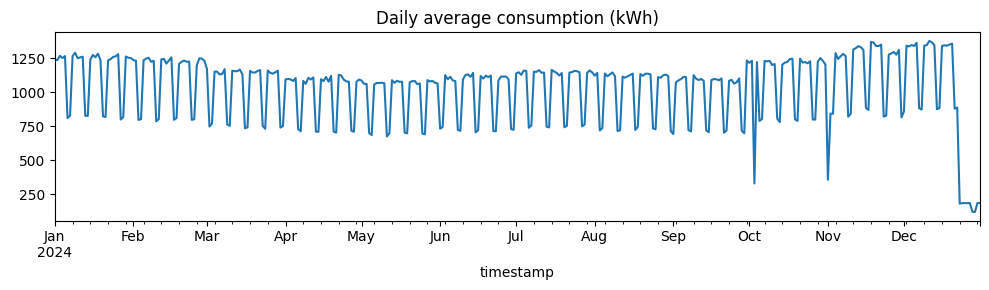

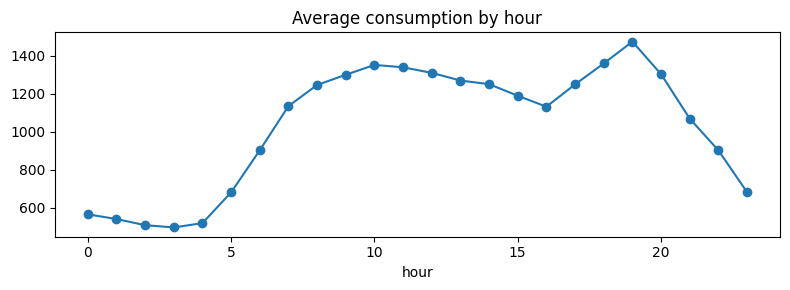

C:\Users\varag\AppData\Local\Temp\ipykernel_31124\3556761692.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['consumption_kwh'].resample('M').sum().plot(kind='bar', title='Monthly total consumption (kWh)')


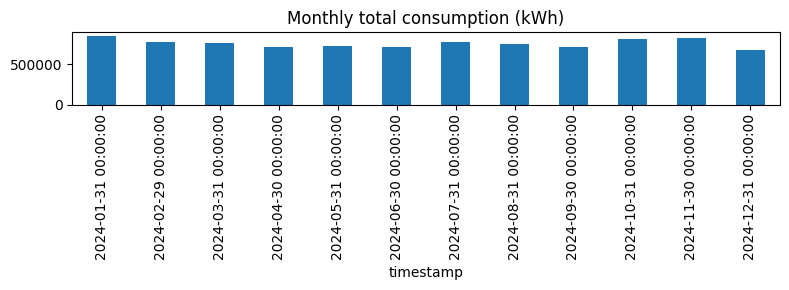

In [8]:
# 1) Check number of rows is 8784 (one per hour in leap year 2024)
assert len(df) == 8784, "There should be 8784 hourly rows for 2024"
print("Row count check passed:", len(df))

# 2) Basic statistics
print("\nConsumption summary (kWh):")
print(df['consumption_kwh'].describe())

# 3) Simple plots for visual checks (these help graders see the pattern)
# Daily average plot (one dot per day)
plt.figure(figsize=(10,3))
df['consumption_kwh'].resample('D').mean().plot(title='Daily average consumption (kWh)')
plt.tight_layout()
plt.show()

# Average by hour (shows day/night pattern)
plt.figure(figsize=(8,3))
df.groupby('hour')['consumption_kwh'].mean().plot(marker='o', title='Average consumption by hour')
plt.tight_layout()
plt.show()

# Monthly totals bar chart
plt.figure(figsize=(8,3))
df['consumption_kwh'].resample('M').sum().plot(kind='bar', title='Monthly total consumption (kWh)')
plt.tight_layout()
plt.show()


# Export the CSV and final note

This saves only the timestamp and the consumption_kwh column to a CSV.

In [9]:

export_df = df.reset_index()[['timestamp', 'consumption_kwh']].copy()

# Convert timestamp to simple Indian readable format
export_df['timestamp'] = export_df['timestamp'].dt.strftime('%d-%m-%Y %H:%M')

# Round consumption values to 2 decimals (simple Indian format)
export_df['consumption_kwh'] = export_df['consumption_kwh'].round(2)

# EXPORT USING SEMICOLON so Excel in Germany splits columns correctly
export_df.to_csv('university_consumption_2024_with_calendar.csv', index=False, sep=';')

